In [1]:
import numpy as np
import math 
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from decimal import Decimal
#params:
V = 63
EPS = 0.00001
n = 7 + V % 15
p = 0.2 + 0.005*V
N = 200
lamb = 1 + 0.02*V
q = 1 - p

distrub_geom = np.random.geometric(p, N) - 1
distrub_poisson = np.random.poisson(lamb, N)
distrub_binom = np.random.binomial(n, p, N)


In [2]:
print(n, p, N, lamb, q, sep='\t')

10	0.515	200	2.26	0.485


In [3]:
def get_frequency_table(xs):
    df = pd.DataFrame({"values" :xs})
    df = pd.value_counts(df["values"]).to_frame().reset_index()
    df.columns = ['Value','Count']
    df = df.sort_values(by=['Value']) #Сортировка по значению
    df.reset_index(inplace = True, drop = True)
    return df

In [4]:
def count_edf(freqs):
    edf = [0]
    s = 0
    for i in freqs:
        s += i
        edf.append(round(s, 5))
    return edf

In [5]:
def count_k_moment(table, k):
    return sum(table.Frequency * table.Value**k)

In [6]:
def count_emperical_mean(table):
    return count_k_moment(table, 1)

In [7]:
def count_centr_k_moment(table, k):
    mean = count_emperical_mean(table)
    return sum((table.Value - mean)**k * table.Frequency)

In [8]:
def plot_edf(edf, values):
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111)
    W = 0.005
    n = len(values)
    if (values[0] != 0): 
        plt.arrow(values[0] - 1,0,1,0,width=W,head_width = 0.02)
    
    for i in range(n - 1):
        plt.arrow(values[i], edf[i+1], values[i+1] - values[i], 0,width=W, head_width = 0.02)
    ax.set(
        xticks = np.arange(values[0], values[n - 1] + 1),
        yticks = np.arange(edf[0], edf[-1] + 0.1, 0.1))      

In [9]:
def count_emperical_dispersion(table):
    mean = count_emperical_mean(table)
    sqr = sum(table.Frequency * table.Value**2)
    return sqr - mean**2

In [10]:
def count_emperical_std(table):
    return np.sqrt(count_emperical_dispersion(table))

In [11]:
def count_moda(table):
    moda = max(table.Count)    
    indx = table.Count[table.Count == moda].index.tolist() 
    if len(indx) == 1:
        return int(table.Value[indx])
    for j in range(1, len(indx)):
        if abs(indx[j] - indx[j-1]) > 1:
            return "Выборочной моды не существует"
    return 1/2*(table.Value[indx[0]] + table.Value[indx[-1]])


In [12]:
def count_skewness(table):
    std = count_emperical_std(table)
    num = count_centr_k_moment(table, 3)
    return num / (std**3)

In [13]:
def count_kurtosis(table):
    std = count_emperical_std(table)
    num = count_centr_k_moment(table, 4)
    return num/(std**4) - 3

In [14]:
def plot_table(table, table_comp):
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111)
    plt.plot(table.Value, table.Frequency, color='b')
    plt.plot(table_comp.Value, table_comp.P, color="r")
    plt.scatter(table.Value, table.Frequency, color="black")
    plt.scatter(table_comp.Value, table_comp.P, color="black")
    ax.set(
        xticks = table_comp.Value)

In [15]:
#таблица сравнения относительных частот и теоретических вероятностей
def create_table_comp(table, type_):
    n = max(table.Value) + 1
    table_comp = pd.DataFrame()
    table_comp['Value'] = np.arange(0, n)
    
    if type_ == "binom":
        table_comp['P'] = np.zeros(n)
        for i in range(n):
            table_comp.P[i] = math.comb(n, i)*(p**i)*(q**(n-i))
    
    if type_ == "geom":
        table_comp['P'] = (q**table_comp.Value)*p
    
    if type_ == "poisson":
        table_comp['P'] = np.zeros(n)
        for i in range(n):
            table_comp.P[i] = (lamb**i)/math.factorial(i)*np.exp(-lamb)

    return table_comp

In [16]:
def main_count(xs, type_):
    mean = 0
    dispersion = 0
    std = 0
    skewness = 0
    kurtosis = 0
    moda = 0
    median = 0

    table = get_frequency_table(xs)
    table['Frequency'] = table.Count / N
    
    edf = count_edf(table.Frequency) # Empirical distribution function list[float]
    emp_mean = count_emperical_mean(table)
    emp_disp = count_emperical_dispersion(table)
    emp_std  = count_emperical_std(table)
    emp_skewness = count_skewness(table)
    emp_kurtosis = count_kurtosis(table)
    
    table_comp = create_table_comp(table, type_)
    plot_table(table, table_comp)
    print(table_comp)
    
    if type_ == "binom":
        mean = n*p
        dispersion = n*p*q
        std = np.sqrt(dispersion)
        if int((n+1)*p) - (n+1)*p == 0:
            moda = (n+1)*p - 1/2
        else:
            moda = int((n+1)*p)
        median = int(n*p)
        skewness = (q - p) / np.sqrt(n*p*q)
        kurtosis = (1 - 6*p*q) / (n*p*q)
        
    if type_ == "poisson":
        mean = lamb
        dispersion = lamb
        std = np.sqrt(lamb)
        moda = int(lamb)
        median = int(lamb + 1/3 - 0.02/lamb)
        skewness = 1/np.sqrt(lamb)
        kurtosis = 1/lamb
        
    if type_ == "geom":
        mean = q/p
        dispersion = q/p/p
        std = np.sqrt(q)/p
        moda = 0
        if int(np.log(2)/np.log(q)) - np.log(2)/np.log(q) == 0:
            median = -np.log(2)/np.log(q) - 1/2
        else:
            median = int(-np.log(2)/np.log(q))
        skewness = (2-p)/np.sqrt(q)
        kurtosis = 6+p*p/q
        
    print(table, end='\n\n')
    print("EDF : ", edf, end='\n\n')
    plot_edf(edf, table.Value)
    
    print("emperical_mean :",emp_mean, end='\n\n' )
    print("emperical_disp :",emp_disp, end='\n\n' )
    print("emperical_std  :",emp_std, end='\n\n' )
    print("emperical moda : ", count_moda(table), end='\n\n')
    print("emp_skewness  :",emp_skewness, end='\n\n' )
    print("emp_kurtosis: ", emp_kurtosis, end='\n\n\n\n')
    
    print("theoretical characteristics:", end='\n\n')
    print("mean:", mean, end='\n\n')
    print("disp:", dispersion, end='\n\n')
    print("std:", std, end='\n\n')
    print("moda: ", moda, end='\n\n')
    print("median: ", median, end='\n\n')
    print("skewness  :", skewness, end='\n\n' )
    print("kurtosis: ", kurtosis, end='\n\n')

In [17]:
def print_file(xs, type_):
    with open(type_ + ".txt", 'w') as file1:
        for x in xs:
            print(x, end='\n', file=file1)

    with open("sort" + type_ + ".txt", 'w') as file2:
        for x in np.sort(xs):
            print(x, end='\n', file=file2)
            
print_file(distrub_geom, "geom")
print_file(distrub_binom, "binom")
print_file(distrub_poisson, "poisson")


   Value         P
0      0  0.515000
1      1  0.249775
2      2  0.121141
3      3  0.058753
4      4  0.028495
5      5  0.013820
6      6  0.006703
7      7  0.003251
   Value  Count  Frequency
0      0     98      0.490
1      1     56      0.280
2      2     27      0.135
3      3     12      0.060
4      4      4      0.020
5      5      2      0.010
6      7      1      0.005

EDF :  [0, 0.49, 0.77, 0.905, 0.965, 0.985, 0.995, 1.0]

emperical_mean : 0.895

emperical_disp : 1.3739750000000002

emperical_std  : 1.1721667970045901

emperical moda :  0

emp_skewness  : 1.750332790824785

emp_kurtosis:  4.065314925792046



theoretical characteristics:

mean: 0.9417475728155339

disp: 1.8286360637194832

std: 1.35227070652273

moda:  0

median:  0

skewness  : 2.132335731094682

kurtosis:  6.546855670103093



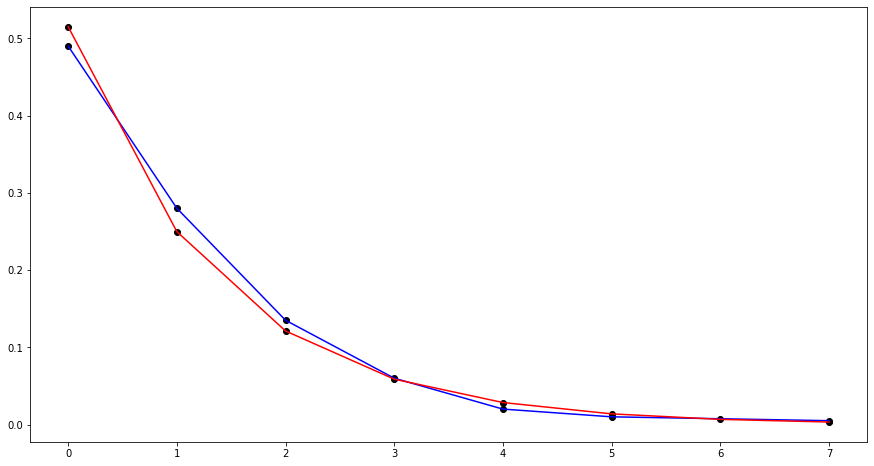

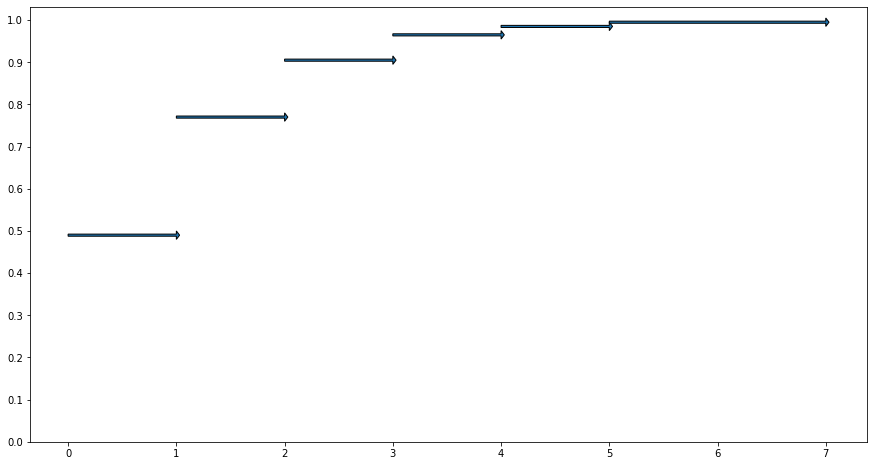

In [18]:
main_count(distrub_geom, "geom")

   Value         P
0      0  0.104350
1      1  0.235832
2      2  0.266490
3      3  0.200756
4      4  0.113427
5      5  0.051269
6      6  0.019311
7      7  0.006235
   Value  Count  Frequency
0      0     22      0.110
1      1     40      0.200
2      2     67      0.335
3      3     41      0.205
4      4     17      0.085
5      5      6      0.030
6      6      6      0.030
7      7      1      0.005

EDF :  [0, 0.11, 0.31, 0.645, 0.85, 0.935, 0.965, 0.995, 1.0]

emperical_mean : 2.1900000000000004

emperical_disp : 2.0238999999999985

emperical_std  : 1.4226383939708638

emperical moda :  2

emp_skewness  : 0.6944512156355482

emp_kurtosis:  0.6132977874232992



theoretical characteristics:

mean: 2.26

disp: 2.26

std: 1.5033296378372907

moda:  2

median:  2

skewness  : 0.6651901052377394

kurtosis:  0.4424778761061947



<ipython-input-15-7dda320d3990>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_comp.P[i] = (lamb**i)/math.factorial(i)*np.exp(-lamb)


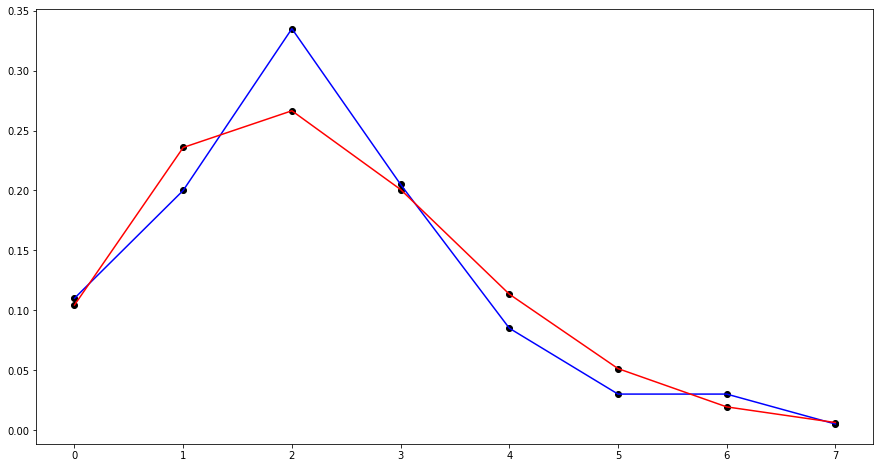

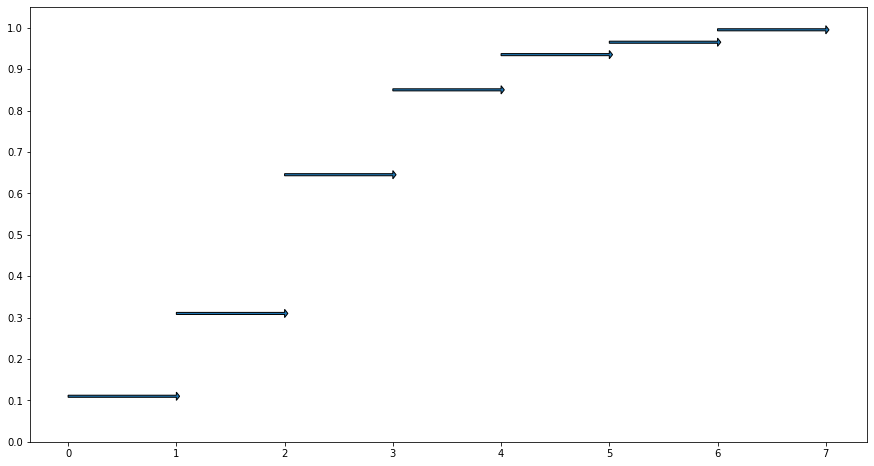

In [19]:
main_count(distrub_poisson, "poisson")

   Value         P
0      0  0.000720
1      1  0.007647
2      2  0.036539
3      3  0.103465
4      4  0.192264
5      5  0.244988
6      6  0.216785
7      7  0.131540
8      8  0.052379
9      9  0.012360
   Value  Count  Frequency
0      1      1      0.005
1      2      8      0.040
2      3     30      0.150
3      4     33      0.165
4      5     47      0.235
5      6     43      0.215
6      7     27      0.135
7      8      9      0.045
8      9      2      0.010

EDF :  [0, 0.005, 0.045, 0.195, 0.36, 0.595, 0.81, 0.945, 0.99, 1.0]

emperical_mean : 5.055

emperical_disp : 2.5219750000000047

emperical_std  : 1.5880727313319138

emperical moda :  5

emp_skewness  : -0.007813140345786913

emp_kurtosis:  -0.5432040865830143



theoretical characteristics:

mean: 5.15

disp: 2.49775

std: 1.580427157448264

moda:  5

median:  5

skewness  : -0.018982209878269627

kurtosis:  -0.19963967570813726



<ipython-input-15-7dda320d3990>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_comp.P[i] = math.comb(n, i)*(p**i)*(q**(n-i))


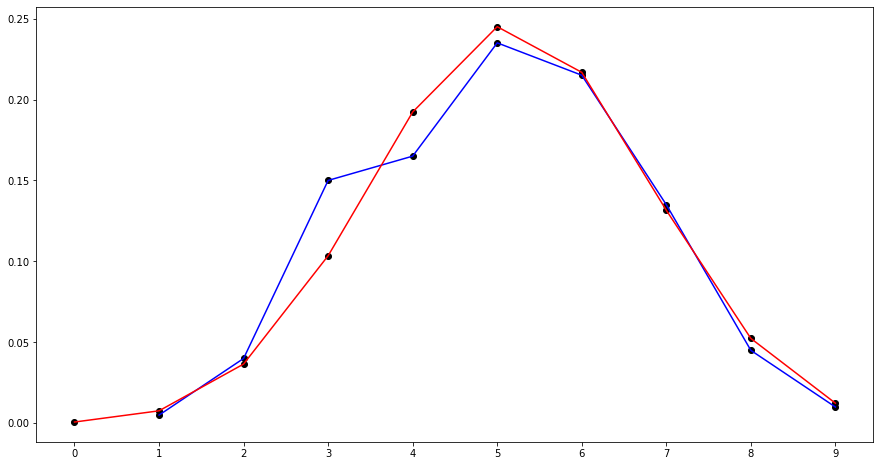

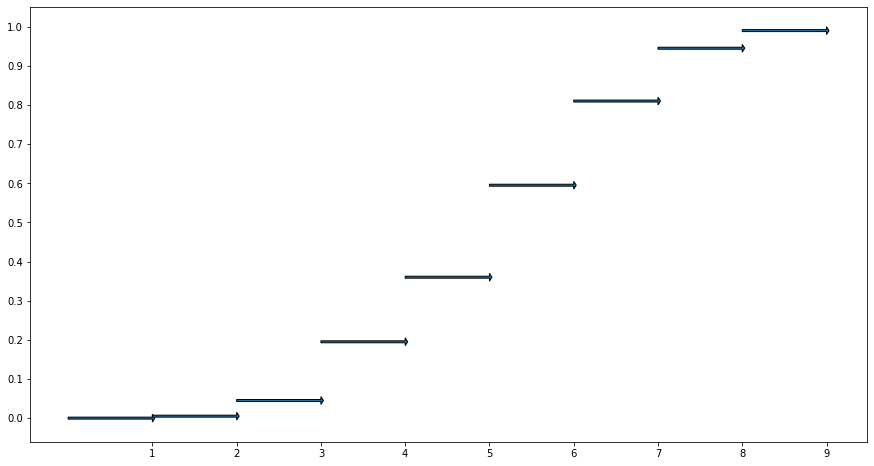

In [21]:
main_count(distrub_binom, "binom")